In [858]:
#Imports necesarios para crear el modelo

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve,auc
from pathlib import Path
import time
from sklearn.model_selection import GridSearchCV


In [ ]:
#cargar x_train, x_test, y_train, y_test 

try:
    x_train = pd.read_csv("../../../data/x_train.csv")
    x_test = pd.read_csv("../../../data/x_test.csv")
    y_train = pd.read_csv("../../../data/y_train.csv")
    y_test = pd.read_csv("../../../data/y_test.csv")
except FileNotFoundError as e:
    print(f"Error: {e}. Verifique la ruta de los archivos.")
    exit(1)

In [860]:
# Archivo donde se guardarán las métricas
ARCHIVO_METRICAS = Path("metrics_arbol_decision.csv")

# Columnas estándar
COLUMNAS = [
    "modelo", "experimento", "accuracy_train", "accuracy_test",
    "recall_train_avg", "recall_test_avg", "f1_train_avg","f1_test_avg" "tiempo_entrenamiento_seg", "overfitting", "observaciones"
]


# FUNCIONES

Vamos a crear algunas funciones con el objetivo de optimizar el codigo evitando repeticiones.Las funciones serán:
- Crear modelos
- Calcular las metricas de rendimiento de cada experimento.
- Guardar las metricas de rendimiento de cada experimento.

In [861]:
def crear_modelo(param_grid, scoring="f1_macro"):
    """
    Crea un modelo DecisionTreeClassifier con GridSearchCV usando el param_grid dado.
    
    Parámetros:
    -----------
    param_grid : dict
        Diccionario con los hiperparámetros a explorar.
    scoring : str, opcional
        Métrica de evaluación para GridSearchCV. Default 'balanced_accuracy'.
    cv : int, opcional
        Número de folds para validación cruzada. Default 5.
    
    Retorna:
    --------
    modelo : GridSearchCV
        Objeto GridSearchCV listo para ajustar.
    """
    modelo = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=42,class_weight='balanced'),
        param_grid=param_grid,
        scoring=scoring,
        cv=5,
        verbose=1
    )
    return modelo

In [862]:
def param_grid_generator(max_depth, min_samples_split, min_samples_leaf,max_features):
    """
    Genera un diccionario de hiperparámetros para GridSearchCV de DecisionTreeClassifier.

    Parámetros:
    -----------
    max_depth : list
        Lista de valores posibles para la profundidad máxima del árbol.
    min_samples_split : list
        Lista de valores posibles para el mínimo de muestras para hacer un split.
    min_samples_leaf : list
        Lista de valores posibles para el mínimo de muestras por hoja.
    max_features : list, opcional
        Lista de valores para el número máximo de características consideradas por split. Default [None].

    Retorna:
    --------
    param_grid : dict
        Diccionario listo para usar en GridSearchCV.
    """
    param_grid = {
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "max_features": max_features,
        "criterion": ["gini"] 
    }
    return param_grid

In [863]:
def calcular_metricas(modelo, x_train,y_train,x_test,y_test):

    """
    Calcula y muestra las métricas principales de un modelo de clasificación multiclase.

    Parámetros:
    -----------
    modelo : objeto entrenado
        Modelo de clasificación ya entrenado (por ejemplo, DecisionTreeClassifier, RandomForestClassifier, etc.).
    x_train : array-like o DataFrame
        Datos de entrenamiento.
    y_train : array-like
        Etiquetas verdaderas del conjunto de entrenamiento.
    x_test : array-like o DataFrame
        Datos de prueba.
    y_test : array-like
        Etiquetas verdaderas del conjunto de prueba.

    Métricas calculadas e impresas:
    -------------------------------
    - Accuracy en entrenamiento
    - Accuracy en test
    - Recall en entrenamiento (promedio ponderado)
    - Recall en test (promedio ponderado)
    - F1-score en entrenamiento (promedio ponderado)
    - F1-score en test (promedio ponderado)

    Retorna:
    --------
    Tuple de 6 floats:
        (accuracy_train, accuracy_test, recall_train, recall_test, f1_train, f1_test)

    Ejemplo de uso:
    ----------------
    acc_train, acc_test, rec_train, rec_test, f1_train, f1_test = calcular_metricas(
        modelo_base, x_train, y_train, x_test, y_test
    )
    """
    #Predicciones
    y_pred_train = modelo.predict(x_train)
    y_pred_test = modelo.predict(x_test)

    #Calcular las metricas

    # Accuracy en entrenamiento
    accuracy_train = accuracy_score(y_train, y_pred_train)
    # Accuracy en test
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # Recall en entrenamiento
    recall_train = recall_score(y_train, y_pred_train,average='macro')
    # Recall en test
    recall_test = recall_score(y_test, y_pred_test, average='macro')
    # F1-score en entrenamiento (balance entre precisión y recall)
    f1_train = f1_score(y_train, y_pred_train, average='macro')
    # F1-score en test
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    
    print("="*60)
    print("TRAIN")
    print("="*60)
    print(f"Accuracy (train): {accuracy_train:.4f}")
    print(f"Recall (train): {recall_train:.4f}")
    print(f"F1-score (train): {f1_train:.4f}")
    print("="*60)
    print("TEST")
    print("="*60)
    print(f"Accuracy (test): {accuracy_test:.4f}")
    print(f"Recall (test): {recall_test:.4f}")
    print(f"F1-score (test): {f1_test:.4f}")

    return y_pred_train,y_pred_test,accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test


In [864]:
def agregar_metrica(modelo, experimento, accuracy_train, accuracy_test,
                    recall_train, recall_test, f1_train, f1_test,
                    tiempo_entrenamiento_seg, overfitting, observaciones,
                    archivo=ARCHIVO_METRICAS):
    """
    Agrega o actualiza las métricas de un modelo de clasificación en un archivo CSV.

    Si el archivo no existe, lo crea con las columnas estándar.

    Parámetros:
    -----------
    modelo : str
        Nombre del modelo.
    experimento : str
        Nombre o identificador del experimento.
    accuracy_train : float
        Accuracy en datos de entrenamiento.
    accuracy_test : float
        Accuracy en datos de prueba.
    recall_train : float
        Recall en entrenamiento.
    recall_test : float
        Recall en test.
    f1_train : float
        F1-score en entrenamiento.
    f1_test : float
        F1-score en test.
    tiempo_entrenamiento_seg : float
        Tiempo de entrenamiento (segundos).
    overfitting : str
        Indica sobreajuste ("Sí" o "No").
    observaciones : str
        Comentarios adicionales.
    archivo : str o Path, opcional
        Ruta del archivo CSV donde se guardarán las métricas.

    Retorna:
    --------
    None
    """

    # Crear DataFrame de la nueva fila
    nueva_fila = pd.DataFrame([{
        "modelo": modelo,
        "experimento": experimento,
        "accuracy_train": accuracy_train,
        "accuracy_test": accuracy_test,
        "recall_train_avg": recall_train,
        "recall_test_avg": recall_test,
        "f1_train_avg": f1_train,
        "f1_test_avg": f1_test,
        "tiempo_entrenamiento_seg": tiempo_entrenamiento_seg,
        "overfitting": overfitting,
        "observaciones": observaciones
    }])

    # Si el archivo existe, cargarlo
    if archivo.exists():
        df = pd.read_csv(archivo)
        
        # Si el experimento ya existe, reemplazar la fila
        if experimento in df['experimento'].values:
            df.loc[df['experimento'] == experimento] = nueva_fila.iloc[0]
            print(f"El experimento '{experimento}' existía. Métricas actualizadas en {archivo}.")
        else:
            df = pd.concat([df, nueva_fila], ignore_index=True)
            print(f"Métrica agregada correctamente a {archivo}.")
    else:
        df = nueva_fila
        print(f"Archivo {archivo} creado y métrica agregada.")

    # Guardar el archivo actualizado
    df.to_csv(archivo, index=False)


In [865]:
def grafico_visualizar_overfitting(metricas,train_scores,test_scores,nombreModelo):
    """
    Crea un gráfico de barras para comparar las métricas de entrenamiento y prueba,
    ayudando a visualizar el posible sobreajuste (overfitting) del modelo.

    Parámetros:
    -----------
    metricas : list of str
        Lista de nombres de las métricas (por ejemplo, ['Accuracy', 'Recall', 'F1-score']).
    train_scores : list of float
        Lista de valores de las métricas en el conjunto de entrenamiento.
    test_scores : list of float
        Lista de valores de las métricas en el conjunto de prueba.

    Retorna:
    --------
    None
        Muestra un gráfico de barras comparativo.
    """
    # Crear gráfico
    x = range(len(metricas))
    plt.figure(figsize=(8,5))
    plt.bar([i-0.15 for i in x], train_scores, width=0.3, label='Train', color='skyblue')
    plt.bar([i+0.15 for i in x], test_scores, width=0.3, label='Test', color='salmon')

    plt.xticks(x, metricas)
    plt.ylim(0,1)
    plt.ylabel('Valor de la métrica')
    plt.title(f'Comparación Train vs Test - {nombreModelo} (Overfitting)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [866]:
def grafico_matriz_confusion(y_test, y_pred_test,nombreExperimento):

    cm = confusion_matrix(y_test, y_pred_test)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')

    plt.title(f"Matriz de Confusión {nombreExperimento} (Test)")
    plt.show()

In [867]:
def guardar_metricas_para_grafico(accuracy_train, accuracy_test,recall_train, recall_test,f1_train, f1_test):    
    
    metricas = ['Accuracy', 'Recall', 'F1-score']
    train_scores = [accuracy_train, recall_train, f1_train]
    test_scores = [accuracy_test, recall_test, f1_test]
    
    return metricas, train_scores, test_scores

<h3>Modelo Base sin Parámetros</h3>

El objetivo de crear este modelo con los parametros por defecto, es dejar que el arbol crezca y nos diga cual es su maximo.

<strong>Predicción sobre su comportamiento:</strong>

Como el árbol puede memorizar todos los datos de entrenamiento, es muy probable que aparezca overfitting.
- El modelo aprenderá perfectamente los patrones del entrenamiento (alta accuracy en train).
- Pero probablemente tendrá peor rendimiento en datos nuevos (accuracy menor en test).

In [868]:
#Entrenar modelo base y guardar cuanto tiempo le toma el entrenamiento

modelo_base = DecisionTreeClassifier(random_state=42)

inicio_base = time.time()
modelo_base.fit(x_train,y_train)
fin_base = time.time()
tiempo_entrenamiento_base = fin_base - inicio_base


In [869]:
#Calcular las metricas del modelo
y_pred_train_base,y_pred_test_base,accuracy_train_base, accuracy_test_base, recall_train_base, recall_test_base, f1_train_base, f1_test_base = calcular_metricas(modelo_base, x_train, y_train, x_test, y_test)

TRAIN
Accuracy (train): 0.8599
Recall (train): 0.7889
F1-score (train): 0.8032
TEST
Accuracy (test): 0.5032
Recall (test): 0.3042
F1-score (test): 0.3017


In [870]:
#Guardar las metricas que serán utilizadas para algunos graficos
metricas, train_scores,test_scores = guardar_metricas_para_grafico(accuracy_train_base, accuracy_test_base,recall_train_base, recall_test_base,f1_train_base, f1_test_base)

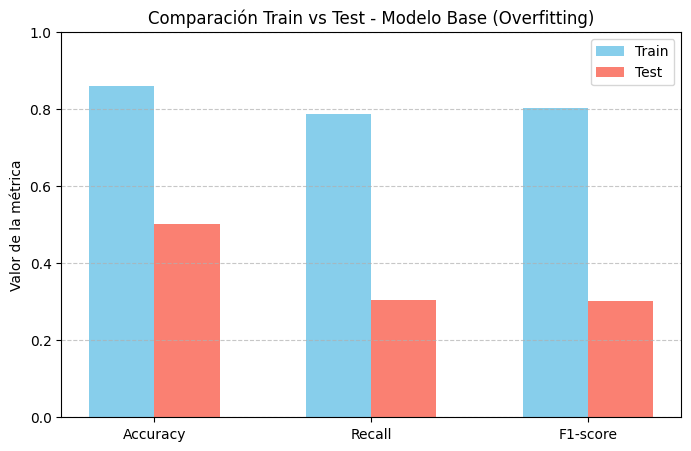

In [871]:
#Visualizar si hay overfitting en el modelo base
grafico_visualizar_overfitting(metricas,train_scores,test_scores,'Modelo Base')

Podemos observar un sobreajuste evidente:las métricas en entrenamiento son muy altas (~0.80) mientras que en test caen significativamente (accuracy ~0.50, F1 ~0.30), mostrando que el modelo memoriza los datos de entrenamiento, osea, overfitting.

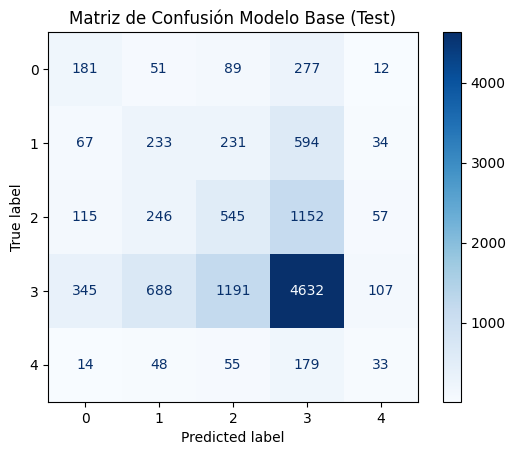

In [872]:
# Mostrar el grafico de la matriz de confusión
grafico_matriz_confusion(y_test, y_pred_test_base,'Modelo Base')

In [906]:
cm = confusion_matrix(y_test, y_pred_test_base)
cm

array([[ 181,   51,   89,  277,   12],
       [  67,  233,  231,  594,   34],
       [ 115,  246,  545, 1152,   57],
       [ 345,  688, 1191, 4632,  107],
       [  14,   48,   55,  179,   33]])

Con la matriz podemos afirmar el overfitting encontrado en el grafico anterior, ademas podemos observar un desvalance en las clases donde la clase 4 concentra la mayoría de las predicciones del modelo lo que muestra un desbalance en el comportamiento del modelo. 

In [873]:
# Mostrar el grafico del arbol
#plt.figure(figsize=(200,100))
#plot_tree(modelo_base, filled=True, class_names=x_train.columns.tolist(), rounded=True)
#plt.show()

In [874]:

print("=== Hiperparámetros del árbol ===")
print(f"Máxima profundidad (max_depth): {modelo_base.get_depth()}")
print(f"Número de hojas (n_leaves): {modelo_base.get_n_leaves()}")
print(f"Máximo número de características consideradas por split (max_features): {modelo_base.max_features}")
print(f"Cantidad mínima de muestras para hacer un split (min_samples_split): {modelo_base.min_samples_split}")
print(f"Cantidad mínima de muestras por hoja (min_samples_leaf): {modelo_base.min_samples_leaf}")
print(f"Limitacion que considera el arbol antes de dividir(max_features): {modelo_base.max_features}")
print(f"Criterio usado para división (criterion): {modelo_base.criterion}")


=== Hiperparámetros del árbol ===
Máxima profundidad (max_depth): 32
Número de hojas (n_leaves): 18729
Máximo número de características consideradas por split (max_features): None
Cantidad mínima de muestras para hacer un split (min_samples_split): 2
Cantidad mínima de muestras por hoja (min_samples_leaf): 1
Limitacion que considera el arbol antes de dividir(max_features): None
Criterio usado para división (criterion): gini


Observando el gráfico del árbol, podemos ver que el modelo base creció hasta una profundidad de 32 niveles y tiene casi 19.000 hojas. Cada hoja puede contener muy pocas muestras, lo que significa que el árbol memoriza casos específicos del entrenamiento. Además, como no hay límite en el número de características consideradas y los splits pueden hacerse con apenas 2 muestras, el árbol termina siendo muy complejo y favorece la clase mayoritaria. Esto explica por qué el modelo presenta overfitting y predice casi siempre la clase 4

<h5>Conclusion:</h5>

El modelo base sin restricciones muestra un sobreajuste evidente: funciona muy bien en entrenamiento, pero falla en test. La matriz de confusión nos muestra que predice casi siempre la clase mayoritaria, ignorando las demás, y el gráfico del árbol confirma que es muy profundo y complejo, con muchas hojas que memorizan los datos. Podemos decir que el modelo cumple su función como referencia, mostrando claramente la importancia de regularizar el árbol y considerar estrategias para balancear las clases antes de buscar un modelo que generalice correctamente


In [ ]:
#Guardar las metricas del modelo en el csv
agregar_metrica('Modelo Arbol de Decisión', 
                'Base',accuracy_train_base,accuracy_test_base,recall_train_base,recall_test_base,
                f1_train_base,f1_test_base,tiempo_entrenamiento_base,
                'Si','Modelo de referencia sin restricciones; presenta overfitting y muestra un desbalance claro, con tendencia a predecir la clase mayoritaria.'
                )

Archivo metrics_arbol_decision.csv creado y métrica agregada.


________________________________________________________________________________

Para realizar los experimentos vamos a crear los modelos con:

class_weight='balanced' --> Esto va a asignar mas peso a las clases minoritarias lo cual puede ayudarnos a equilibrar el desbalance.

scoring='balanced_accuracy' --> Queremos que el GridSearch escoja el mejor modelo en base a su rendimiento equilibrado entre todas las clases, no solo a la cantidad de aciertos totales. De esta forma, cada clase tiene la misma importancia y el modelo que elijamos será el que generalice mejor incluso en las clases con menos ejemplos. 

<h3>EXPERIMENTO 1</h3>

El objetivo de este experimento es reducir la complejidad del arbol esperando que el overfitting sea menor.

Con el modelo base obtuvimos los maximos a los que llega el arbol si lo dejamos crecer libremente por eso, para este experimento:

1. Vamos a reducir la profundidad,y con ayuda de gridsearch vamos a probar varias profundidades, con esto esperamos reducir el overfitting y la complejidad del arbol.

2. Vamos a limitar el tamaño de las hojas para evitar que el arbol memorice casos individuales y generalice.

3. Por ultimo vamos a especificar el minimo de muestras que deben haber para hacer split.

In [876]:
param_grid = param_grid_generator(max_depth=[5, 10, 15], min_samples_split=[3, 5, 10], min_samples_leaf=[5,4,10],max_features=[None])

In [877]:
experimento1= crear_modelo(param_grid)

inicio_exp1 = time.time()
experimento1.fit(x_train,y_train)
fin_exp1 = time.time()
tiempo_entrenamiento_exp1 = fin_exp1 - inicio_exp1

modelo_experimento1 = experimento1.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [878]:
#Calcular las metricas del modelo
y_pred_train_exp1,y_pred_test_exp1,accuracy_train_exp1, accuracy_test_exp1, recall_train_exp1, recall_test_exp1, f1_train_exp1, f1_test_exp1 = calcular_metricas(modelo_experimento1, x_train, y_train, x_test, y_test)

TRAIN
Accuracy (train): 0.2763
Recall (train): 0.3841
F1-score (train): 0.2426
TEST
Accuracy (test): 0.2781
Recall (test): 0.3825
F1-score (test): 0.2419


In [879]:
#Guardar las metricas que serán utilizadas para algunos graficos
metricas_exp1, train_scores_exp1,test_scores_exp1 = guardar_metricas_para_grafico(accuracy_train_exp1, accuracy_test_exp1,recall_train_exp1, recall_test_exp1,f1_train_exp1, f1_test_exp1)

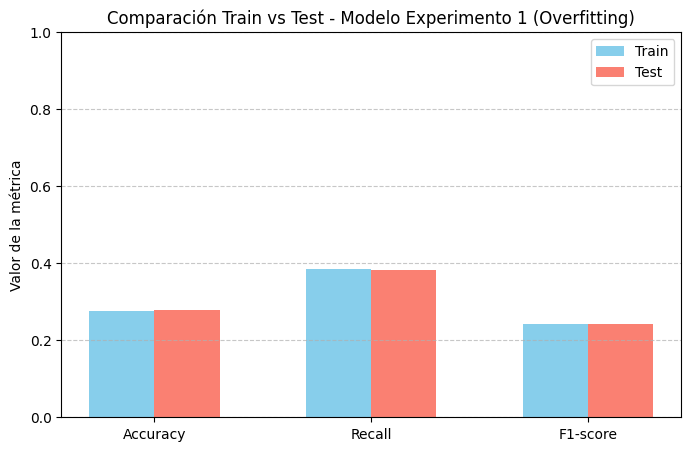

In [880]:
#Visualizar si hay overfitting en el modelo base
grafico_visualizar_overfitting(metricas_exp1,train_scores_exp1,test_scores_exp1,'Modelo Experimento 1')

Podemos ver que las métricas de entrenamiento y de prueba son muy parecidas:

- F1 (train): 0.2426

- F1 (test): 0.2419

Esto indica que el modelo no memoriza los datos, pero tampoco está aprendiendo patrones útiles: es decir, estamos frente a un caso de underfitting.
El árbol probablemente se quedó demasiado simple y no logra representar bien la complejidad del problema.

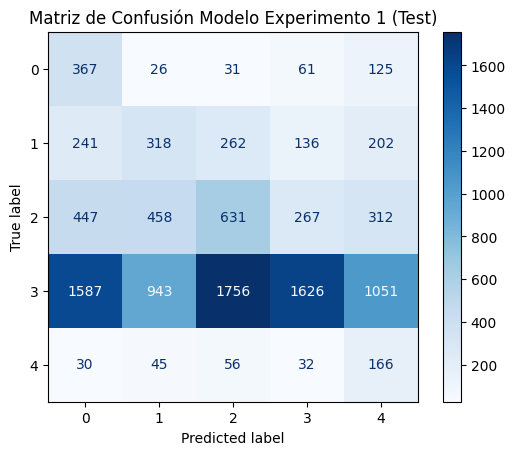

In [881]:
# Mostrar el grafico de la matriz de confusión
grafico_matriz_confusion(y_test, y_pred_test_exp1,'Modelo Experimento 1')

Al observar la matriz, notamos que el modelo se confunde bastante entre todas las clases.
Las predicciones están repartidas de forma más o menos uniforme, sin una clase claramente dominante como en el modelo base.
Esto confirma que el árbol no está captando relaciones fuertes: predice casi al azar, lo que explica las métricas bajas.

In [907]:
cm = confusion_matrix(y_test, y_pred_test_exp1)
cm

array([[ 367,   26,   31,   61,  125],
       [ 241,  318,  262,  136,  202],
       [ 447,  458,  631,  267,  312],
       [1587,  943, 1756, 1626, 1051],
       [  30,   45,   56,   32,  166]])

In [882]:
cm = confusion_matrix(y_test, y_pred_test_exp1)
cm

array([[ 367,   26,   31,   61,  125],
       [ 241,  318,  262,  136,  202],
       [ 447,  458,  631,  267,  312],
       [1587,  943, 1756, 1626, 1051],
       [  30,   45,   56,   32,  166]])

In [883]:
#plt.figure(figsize=(20,10))
#plot_tree(modelo_experimento1, filled=True, class_names=x_train.columns.tolist(), rounded=True)
#plt.show()



In [884]:

print("=== Hiperparámetros del árbol ===")
print(f"Máxima profundidad (max_depth): {modelo_experimento1.get_depth()}")
print(f"Número de hojas (n_leaves): {modelo_experimento1.get_n_leaves()}")
print(f"Cantidad mínima de muestras para hacer un split (min_samples_split): {modelo_experimento1.min_samples_split}")
print(f"Cantidad mínima de muestras por hoja (min_samples_leaf): {modelo_experimento1.min_samples_leaf}")
print(f"Limitacion que considera el arbol antes de dividir(max_features): {modelo_experimento1.max_features}")
print(f"Criterio usado para división (criterion): {modelo_experimento1.criterion}")


=== Hiperparámetros del árbol ===
Máxima profundidad (max_depth): 5
Número de hojas (n_leaves): 32
Cantidad mínima de muestras para hacer un split (min_samples_split): 3
Cantidad mínima de muestras por hoja (min_samples_leaf): 10
Limitacion que considera el arbol antes de dividir(max_features): None
Criterio usado para división (criterion): gini


Estos valores muestran que el árbol está muy limitado en profundidad y tamaño, lo que efectivamente ayuda a evitar el overfitting. Sin embargo, en este caso lo restringimos demasiado, haciendo que el modelo se vuelva tan simple que pierde la capacidad de distinguir correctamente entre las clases.

Conclusión breve:

Este experimento corrigió el sobreajuste del modelo base, pero el árbol quedó demasiado simple y no logra aprender correctamente los patrones de los datos. Es decir, pasamos del overfitting al underfitting.

In [885]:
#Guardar las metricas del modelo en el csv
agregar_metrica('Modelo Arbol de Decisión', 
                'Experimento 1',accuracy_train_exp1,accuracy_test_exp1,recall_train_exp1,recall_test_exp1,
                f1_train_exp1,f1_test_exp1,tiempo_entrenamiento_exp1,
                'No','El árbol evitó el sobreajuste del modelo base, pero quedó demasiado simple y no logra aprender los patrones de los datos, mostrando underfitting.'
                )

Métrica agregada correctamente a metrics_arbol_decision.csv.


EXPERIMENTO 2

El obejtivo es aumentar la capacidad del árbol (menos restricciones que en el Experimento 1) para comprobar si el underfitting disminuye y si el modelo mejora en test sin volver a sobreajustar.

1. max_depth (aumentar), vamos a probar profundidades mayores ([5, 10, 15, 20, 25,30]).Ya que el árbol limitado no pudo aprender patrones complejos; aumentar depth da capacidad para modelar interacciones.

2. min_samples_leaf (reducir / probar valores menores) Vamos a probar valores [ 5,6, 10,15].ya que  hojas más pequeñas permiten más particiones y capturar más patrones.

3. min_samples_split (probar valores bajos/medios)

Usaremos los valores [2, 3, 5, 10], para permitir splits con pocas muestras da flexibilidad; aumentarlo evita splits irrelevantes.

In [886]:
param_grid_exp2 = param_grid_generator(max_depth=[20,25,30], min_samples_split=[6,10,15], min_samples_leaf=[2,3,5,10],max_features=[None])

In [887]:
experimento2= crear_modelo(param_grid_exp2)

inicio_exp2 = time.time()
experimento2.fit(x_train,y_train)
fin_exp2 = time.time()
tiempo_entrenamiento_exp2 = fin_exp2 - inicio_exp2

modelo_experimento2 = experimento2.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [888]:
#Calcular las metricas del modelo
y_pred_train_exp2,y_pred_test_exp2,accuracy_train_exp2, accuracy_test_exp2, recall_train_exp2, recall_test_exp2, f1_train_exp2, f1_test_exp2 = calcular_metricas(modelo_experimento2, x_train, y_train, x_test, y_test)

TRAIN
Accuracy (train): 0.5998
Recall (train): 0.7855
F1-score (train): 0.5644
TEST
Accuracy (test): 0.3468
Recall (test): 0.3234
F1-score (test): 0.2603


In [889]:
#Guardar las metricas que serán utilizadas para algunos graficos
metricas_exp2, train_scores_exp2,test_scores_exp2 = guardar_metricas_para_grafico(accuracy_train_exp2, accuracy_test_exp2,recall_train_exp2, recall_test_exp2,f1_train_exp2, f1_test_exp2)

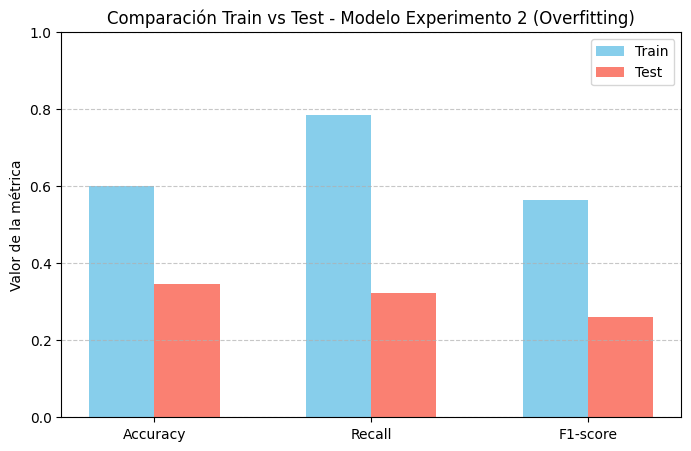

In [890]:
#Visualizar si hay overfitting en el modelo base
grafico_visualizar_overfitting(metricas_exp2,train_scores_exp2,test_scores_exp2,'Modelo Experimento 2')

En este gráfico podemos observar que las métricas en entrenamiento son claramente superiores a las del conjunto de prueba.
El accuracy en entrenamiento ronda el 0.60, mientras que en test cae a 0.34.
Esto indica que el modelo ha aprendido bastante bien los datos de entrenamiento, pero no logra mantener ese rendimiento con datos nuevos.
Podemos decir que el modelo empieza a mostrar signos de overfitting, aunque todavía no tan graves como en el modelo base.

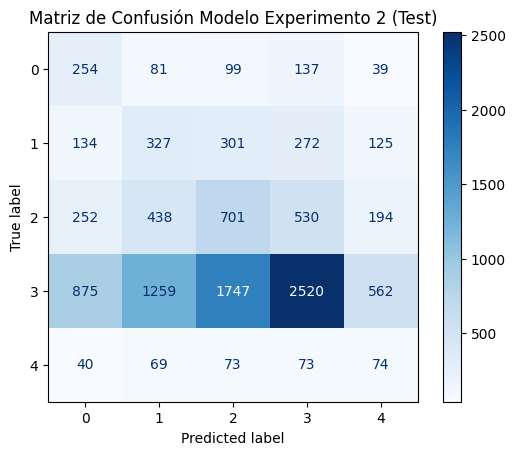

In [891]:
# Mostrar el grafico de la matriz de confusión
grafico_matriz_confusion(y_test, y_pred_test_exp2,'Modelo Experimento 2')

In [892]:
cm = confusion_matrix(y_test, y_pred_test_exp2)
cm

array([[ 254,   81,   99,  137,   39],
       [ 134,  327,  301,  272,  125],
       [ 252,  438,  701,  530,  194],
       [ 875, 1259, 1747, 2520,  562],
       [  40,   69,   73,   73,   74]])

El modelo sigue concentrando la mayoría de las predicciones en la clase más frecuente (clase 3 o 4).
Aunque ahora se observa una pequeña mejora en la distribución, el desbalance sigue presente, y las clases minoritarias siguen siendo mal clasificadas. Desmostrando que el modelo sigue confundiendo muchas clases entre sí, y no logra distinguir correctamente los patrones de las clases con menos ejemplos.

In [893]:
#plt.figure(figsize=(20,10))
#plot_tree(modelo_experimento2, filled=True, class_names=x_train.columns.tolist(), rounded=True)
#plt.show()


In [894]:

print("=== Hiperparámetros del árbol ===")
print(f"Máxima profundidad (max_depth): {modelo_experimento2.get_depth()}")
print(f"Número de hojas (n_leaves): {modelo_experimento2.get_n_leaves()}")
print(f"Cantidad mínima de muestras para hacer un split (min_samples_split): {modelo_experimento2.min_samples_split}")
print(f"Cantidad mínima de muestras por hoja (min_samples_leaf): {modelo_experimento2.min_samples_leaf}")
print(f"Limitacion que considera el arbol antes de dividir(max_features): {modelo_experimento2.max_features}")
print(f"Criterio usado para división (criterion): {modelo_experimento2.criterion}")


=== Hiperparámetros del árbol ===
Máxima profundidad (max_depth): 30
Número de hojas (n_leaves): 11236
Cantidad mínima de muestras para hacer un split (min_samples_split): 6
Cantidad mínima de muestras por hoja (min_samples_leaf): 2
Limitacion que considera el arbol antes de dividir(max_features): None
Criterio usado para división (criterion): gini


El árbol creció significativamente comparado con el experimento anterior (de 32 hojas a más de 2800), lo que confirma que ahora tiene mucha más capacidad de aprendizaje.Aunque el árbol aprendió más patrones del conjunto de entrenamiento, no logró transferir ese conocimiento a los datos nuevos.

CONCLUSION:

El experimento 2 logró aumentar la capacidad del modelo para aprender los patrones del conjunto de entrenamiento, reduciendo parcialmente el underfitting del experimento anterior.
Sin embargo, al hacerlo, el árbol volvió a caer en overfitting y no consiguió mejorar su rendimiento en los datos de prueba.
El desbalance entre clases sigue afectando las predicciones, y el modelo continúa favoreciendo la clase más frecuente.

In [895]:
#Guardar las metricas del modelo en el csv
agregar_metrica('Modelo Arbol de Decisión', 
                'Experimento 2',accuracy_train_exp2,accuracy_test_exp2,recall_train_exp2,recall_test_exp2,
                f1_train_exp2,f1_test_exp2,tiempo_entrenamiento_exp2,
                'Leve','El modelo creció en complejidad y redujo parcialmente el underfitting, pero no logró mejorar las métricas en test.'
                )

Métrica agregada correctamente a metrics_arbol_decision.csv.


EXPERIMENTO 3

En este experimento quisimos ver qué pasaba si el árbol no podía usar todas las variables en cada división.
Antes, al tener acceso a todas, siempre elegía las mismas y se sobreajustaba.
Ahora, con max_features limitado, el modelo tiene que "pensar" con menos información en cada nodo, lo que lo obliga a buscar combinaciones distintas y a generalizar mejor.
En teoría, esto debería ayudar a reducir el overfitting y mejorar el desempeño en test, aunque quizás baje un poco el accuracy en train.

In [896]:
param_grid_exp3 = param_grid_generator(max_depth=[5,10,15,20,25,30,None], min_samples_split=[3,5,6,10,15], min_samples_leaf=[2,3,5,10],max_features = ['sqrt', 'log2'])

In [897]:
experimento3= crear_modelo(param_grid_exp3)

inicio_exp3 = time.time()
experimento3.fit(x_train,y_train)
fin_exp3 = time.time()
tiempo_entrenamiento_exp3 = fin_exp3 - inicio_exp3

modelo_experimento3 = experimento3.best_estimator_

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


In [898]:
#Calcular las metricas del modelo
y_pred_train_exp3,y_pred_test_exp3,accuracy_train_exp3, accuracy_test_exp3, recall_train_exp3, recall_test_exp3, f1_train_exp3, f1_test_exp3 = calcular_metricas(modelo_experimento3, x_train, y_train, x_test, y_test)

TRAIN
Accuracy (train): 0.4918
Recall (train): 0.6805
F1-score (train): 0.4521
TEST
Accuracy (test): 0.3168
Recall (test): 0.3341
F1-score (test): 0.2488


In [899]:
#Guardar las metricas que serán utilizadas para algunos graficos
metricas_exp3, train_scores_exp3,test_scores_exp3 = guardar_metricas_para_grafico(accuracy_train_exp3, accuracy_test_exp3,recall_train_exp3, recall_test_exp3,f1_train_exp3, f1_test_exp3)

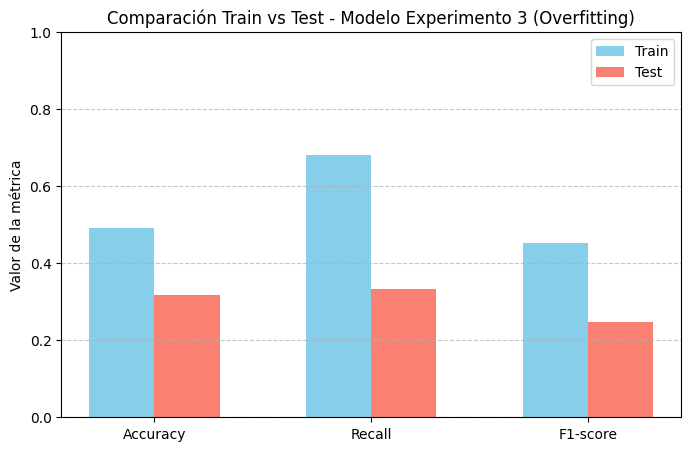

In [900]:
#Visualizar si hay overfitting en el modelo base
grafico_visualizar_overfitting(metricas_exp3,train_scores_exp3,test_scores_exp3,'Modelo Experimento 3')

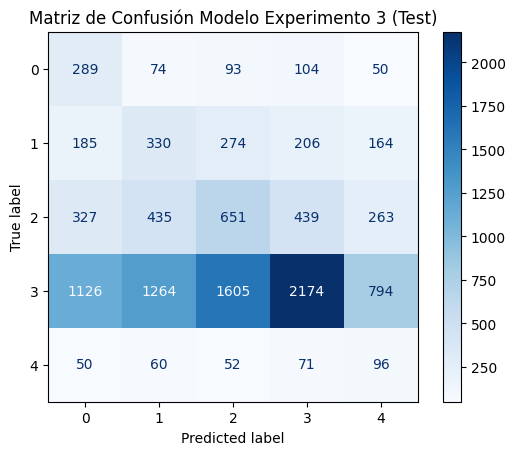

In [901]:
# Mostrar el grafico de la matriz de confusión
grafico_matriz_confusion(y_test, y_pred_test_exp3,'Modelo Experimento 3')

In [902]:
cm = confusion_matrix(y_test, y_pred_test_exp3)
cm

array([[ 289,   74,   93,  104,   50],
       [ 185,  330,  274,  206,  164],
       [ 327,  435,  651,  439,  263],
       [1126, 1264, 1605, 2174,  794],
       [  50,   60,   52,   71,   96]])

In [903]:
#plt.figure(figsize=(20,10))
#plot_tree(modelo_experimento3, filled=True, class_names=x_train.columns.tolist(), rounded=True)
#plt.show()

In [904]:

print("=== Hiperparámetros del árbol ===")
print(f"Máxima profundidad (max_depth): {modelo_experimento3.get_depth()}")
print(f"Número de hojas (n_leaves): {modelo_experimento3.get_n_leaves()}")
print(f"Cantidad mínima de muestras para hacer un split (min_samples_split): {modelo_experimento3.min_samples_split}")
print(f"Cantidad mínima de muestras por hoja (min_samples_leaf): {modelo_experimento3.min_samples_leaf}")
print(f"Limitacion que considera el arbol antes de dividir(max_features): {modelo_experimento3.max_features}")
print(f"Criterio usado para división (criterion): {modelo_experimento3.criterion}")


=== Hiperparámetros del árbol ===
Máxima profundidad (max_depth): 25
Número de hojas (n_leaves): 9102
Cantidad mínima de muestras para hacer un split (min_samples_split): 3
Cantidad mínima de muestras por hoja (min_samples_leaf): 2
Limitacion que considera el arbol antes de dividir(max_features): sqrt
Criterio usado para división (criterion): gini


In [905]:
#Guardar las metricas del modelo en el csv
agregar_metrica('Modelo Arbol de Decisión', 
                'Experimento 3',accuracy_train_exp3,accuracy_test_exp3,recall_train_exp3,recall_test_exp3,
                f1_train_exp3,f1_test_exp3,tiempo_entrenamiento_exp3,
                'Si','El modelo mejoró ligeramente la generalización, aunque las métricas en test siguen bajas y el desbalance de clases continúa afectando el rendimiento.'
                )

Métrica agregada correctamente a metrics_arbol_decision.csv.
